#Librerias

In [ ]:
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.signal import decimate
from collections import Counter

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import joblib
from google.colab import drive

#Configuraciones generales

In [ ]:
drive.mount('/content/drive')

PKL_FOLDER = "/content/drive/MyDrive/Colab Notebooks/TESIS/dataset_sujetos"

LABEL_MAP = {4: 0, 3: 1, 2: 2}   # 0=relajado, 1=tensión, 2=estrés

Mounted at /content/drive


#Carga de archivos PKL

In [ ]:
def load_pkl(path):
    """Carga un archivo .pkl con encoding latino."""
    with open(path, "rb") as f:
        return pickle.load(f, encoding="latin1")


def load_all_subjects(folder):
    """Carga todos los sujetos .pkl."""
    files = sorted(glob.glob(folder + "/*.pkl"))
    subjects = [load_pkl(f) for f in files]
    print(f"Sujetos cargados: {len(subjects)}")
    return subjects

In [ ]:
subjects = load_all_subjects(PKL_FOLDER)

✔ Sujetos cargados: 15


#Limpieza y normalización de señales

In [ ]:
def remove_acc(data):
  """Elimina sensores ACC innecesarios."""
  data["signal"]["chest"].pop("ACC", None)
  data["signal"]["wrist"].pop("ACC", None)
  return data

In [ ]:
subjects = [remove_acc(s) for s in subjects]

In [ ]:
def normalize_subject(data):
  """Normaliza todas las señales entre 0–1."""
  scaler = MinMaxScaler()
  out = {"signal": {}}

  for part, channels in data["signal"].items():
      out["signal"][part] = {}
      for ch_name, ch_data in channels.items():
          arr = np.array(ch_data).reshape(-1, 1)
          out["signal"][part][ch_name] = scaler.fit_transform(arr).flatten()

  out["label"] = data["label"]
  return out

In [ ]:
subjects = [normalize_subject(s) for s in subjects]

#Alineacion ches-wrist

In [ ]:
def interpolate_to_700(arr, target_len):
  """Interpola señales wrist (~4 Hz) a 700 Hz."""
  x_old = np.linspace(0, 1, len(arr))
  x_new = np.linspace(0, 1, target_len)
  return np.interp(x_new, x_old, arr)

In [ ]:
def align_subject(data):
  """Alinea señales del sujeto y recorta al mínimo común."""
  chest = data["signal"]["chest"]
  wrist = data["signal"]["wrist"]

  temp_key = "Temp" if "Temp" in wrist else "TEMP"

  chest_matrix = np.vstack([chest["ECG"], chest["EMG"], chest["EDA"],
                            chest["Temp"], chest["Resp"]])
  chest_len = chest_matrix.shape[1]

  wrist_matrix = np.vstack([
      interpolate_to_700(wrist["BVP"], chest_len),
      interpolate_to_700(wrist["EDA"], chest_len),
      interpolate_to_700(wrist[temp_key], chest_len)
  ])

  S = np.vstack([chest_matrix, wrist_matrix])

  min_len = min(S.shape[1], len(data["label"]))
  S = S[:, :min_len]
  Y = np.array(data["label"][:min_len])

  return S[:, :min_len], np.array(data["label"][:min_len])

#Creacion de ventanas

In [ ]:
def create_windows(data, win=7000, step=7000):
  """Genera ventanas de señal y etiqueta por mayoría."""
  S, labels = align_subject(data)
  X, Y = [], []

  for start in range(0, len(labels) - win, step):
    end = start + win
    win_labels = labels[start:end]

    majority = np.argmax(np.bincount(win_labels))

    if majority not in LABEL_MAP:
        continue

    X.append(S[:, start:end])
    Y.append(majority)

  return np.array(X), np.array(Y)

In [ ]:
def relabel_vector(Y):
  """Aplica el mapeo final de clases."""
  return np.array([LABEL_MAP[y] for y in Y if y in LABEL_MAP])

#Extraccion de features

In [ ]:
def extract_features(X):
  """Crea vectores con estadísticas básicas por canal."""
  feats = []
  for win in X:
      feats.append(np.hstack([
          win.mean(axis=1),
          win.std(axis=1),
          win.min(axis=1),
          win.max(axis=1)
      ]))
  return np.array(feats)

#Validación Leave-One-Subject-Out (LOSO)

In [ ]:
def run_LOSO(subjects):
  results = {
      "RF": {"acc": [], "f1": [], "prec": [], "rec": []},
      "LR": {"acc": [], "f1": [], "prec": [], "rec": []},
      "SVM": {"acc": [], "f1": [], "prec": [], "rec": []},
      "CM_RF": np.zeros((3, 3)),
      "CM_LR": np.zeros((3, 3)),
      "CM_SVM": np.zeros((3, 3)),
  }

  N = len(subjects)
  print("\n========= EJECUTANDO VALIDACIÓN LOSO =========\n")

  for test_idx in range(N):
      print(f"→ Sujeto de prueba: {test_idx}")

      # ---- TEST ----
      X_test, y_test = create_windows(subjects[test_idx])
      y_test = relabel_vector(y_test)

      # ---- TRAIN ----
      X_train, y_train = [], []
      for i in range(N):
          if i == test_idx:
              continue
          Xi, Yi = create_windows(subjects[i])
          X_train.append(Xi)
          y_train.append(relabel_vector(Yi))

      X_train = np.vstack(X_train)
      y_train = np.hstack(y_train)

      # ---- Features ----
      F_train = extract_features(X_train)
      F_test = extract_features(X_test)

      scaler = StandardScaler()
      F_train_s = scaler.fit_transform(F_train)
      F_test_s = scaler.transform(F_test)

      # ---- Modelos ----
      models = {
          "RF": RandomForestClassifier(n_estimators=300, class_weight="balanced"),
          "LR": LogisticRegression(max_iter=2000, class_weight="balanced"),
          "SVM": SVC(kernel="rbf", class_weight="balanced")
      }

      for key, model in models.items():
          model.fit(F_train_s, y_train)
          pred = model.predict(F_test_s)

          results[key]["acc"].append(accuracy_score(y_test, pred))
          results[key]["f1"].append(f1_score(y_test, pred, average="macro"))
          results[key]["prec"].append(precision_score(y_test, pred, average="macro", zero_division=0))
          results[key]["rec"].append(recall_score(y_test, pred, average="macro"))
          results[f"CM_{key}"] += confusion_matrix(y_test, pred, labels=[0, 1, 2])

  # ---- Selección del mejor modelo ----
  best = max(["RF", "LR", "SVM"], key=lambda m: np.mean(results[m]["f1"]))
  print("\n Mejor modelo según LOSO:", best)

  # ---- Entrenamiento FINAL ----
  print("\nEntrenando modelo final con todos los sujetos...")

  X_all, Y_all = [], []
  for s in subjects:
      Xi, Yi = create_windows(s)
      X_all.append(Xi)
      Y_all.append(relabel_vector(Yi))

  X_all = np.vstack(X_all)
  Y_all = np.hstack(Y_all)

  F_all = extract_features(X_all)
  scaler_final = StandardScaler()
  F_all_scaled = scaler_final.fit_transform(F_all)

  if best == "RF":
      model_final = RandomForestClassifier(n_estimators=300, class_weight="balanced")
  elif best == "LR":
      model_final = LogisticRegression(max_iter=2000, class_weight="balanced")
  else:
      model_final = SVC(kernel="rbf", class_weight="balanced", probability=True)

  model_final.fit(F_all_scaled, Y_all)

  joblib.dump(model_final, "/content/drive/MyDrive/modelo_final.pkl")
  joblib.dump(scaler_final, "/content/drive/MyDrive/scaler_final.pkl")

  print("✔ Modelo final guardado como modelo_final.pkl")
  return results, best

In [ ]:
results, best_model_name = run_LOSO(subjects)


========= EJECUTANDO VALIDACIÓN LOSO =========

→ Sujeto de prueba: 0
→ Sujeto de prueba: 1
→ Sujeto de prueba: 2
→ Sujeto de prueba: 3
→ Sujeto de prueba: 4
→ Sujeto de prueba: 5
→ Sujeto de prueba: 6
→ Sujeto de prueba: 7
→ Sujeto de prueba: 8
→ Sujeto de prueba: 9
→ Sujeto de prueba: 10
→ Sujeto de prueba: 11
→ Sujeto de prueba: 12
→ Sujeto de prueba: 13
→ Sujeto de prueba: 14

 Mejor modelo según LOSO: SVM

Entrenando modelo final con todos los sujetos...
✔ Modelo final guardado como modelo_final.pkl


#Visualizaciones

In [ ]:
def plot_f1_comparison(results):
  models = ["RF", "LR", "SVM"]
  f1_means = [np.mean(results[m]["f1"]) for m in models]
  f1_std = [np.std(results[m]["f1"]) for m in models]

  plt.figure(figsize=(8, 5))
  x = np.arange(len(models))

  plt.bar(x, f1_means, yerr=f1_std, capsize=8,
          alpha=0.8, color=["purple", "orange", "green"])

  plt.xticks(x, models)
  plt.ylabel("Macro F1-score")
  plt.title("Comparación de Macro-F1 promedio (LOSO)")
  plt.grid(axis="y", linestyle="--", alpha=0.4)
  plt.show()

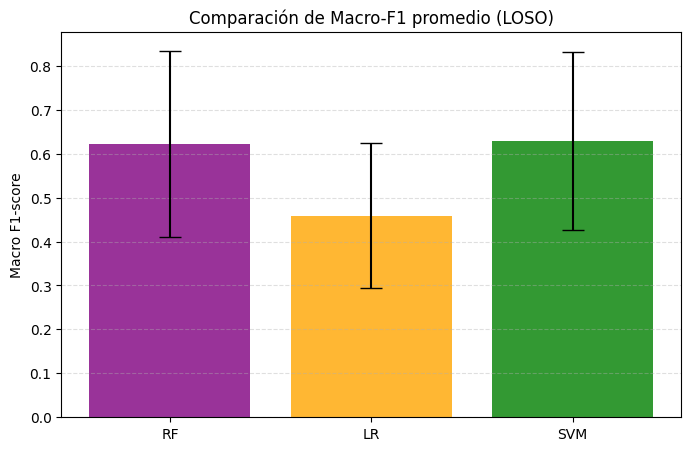

In [ ]:
plot_f1_comparison(results)

In [ ]:
def plot_LOSO_confusion_matrices(results):
  labels = ["Relajado", "Tensión", "Estrés"]
  matrices = {
      "Random Forest": results["CM_RF"],
      "Logistic Regression": results["CM_LR"],
      "SVM": results["CM_SVM"]
  }

  for name, cm in matrices.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusión acumulada (LOSO)\n{name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

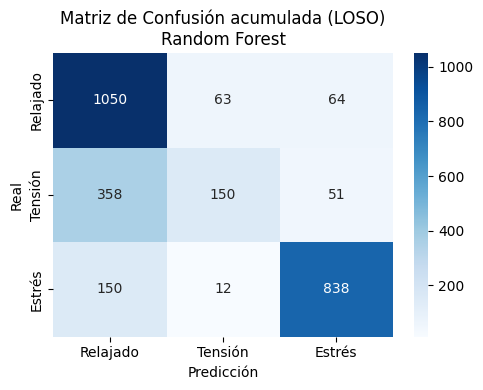

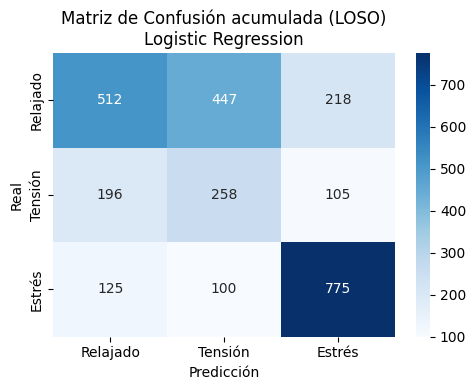

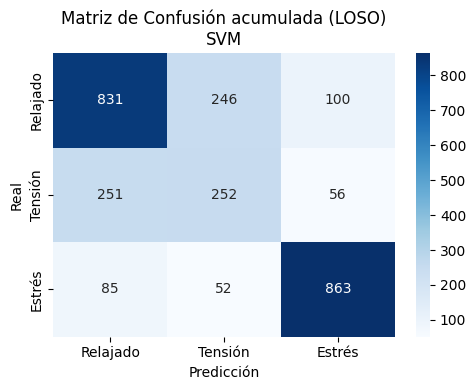

In [ ]:
plot_LOSO_confusion_matrices(results)

#Tabla Resumen

In [ ]:
def loso_metrics_table(results):
  return pd.DataFrame({
      "Modelo": ["Random Forest", "Logistic Regression", "SVM"],
      "Accuracy Promedio": [
          np.mean(results["RF"]["acc"]),
          np.mean(results["LR"]["acc"]),
          np.mean(results["SVM"]["acc"])
      ],
      "F1-score Promedio": [
          np.mean(results["RF"]["f1"]),
          np.mean(results["LR"]["f1"]),
          np.mean(results["SVM"]["f1"])
      ],
      "Precisión Promedio": [
          np.mean(results["RF"]["prec"]),
          np.mean(results["LR"]["prec"]),
          np.mean(results["SVM"]["prec"])
      ],
      "Recall Promedio": [
          np.mean(results["RF"]["rec"]),
          np.mean(results["LR"]["rec"]),
          np.mean(results["SVM"]["rec"])
      ],
      "Desv. Estándar F1": [
          np.std(results["RF"]["f1"]),
          np.std(results["LR"]["f1"]),
          np.std(results["SVM"]["f1"])
      ]
  })

In [ ]:
+6df_summary = loso_metrics_table(results)
print(df_summary)

                Modelo  Accuracy Promedio  F1-score Promedio  \
0        Random Forest           0.745047           0.622523   
1  Logistic Regression           0.564282           0.458942   
2                  SVM           0.711292           0.629362   

   Precisión Promedio  Recall Promedio  Desv. Estándar F1  
0            0.672633         0.667852           0.211911  
1            0.542343         0.557450           0.165729  
2            0.655796         0.675727           0.202392  


#